## 75.06/95.58 Organización de Datos -  Primer Cuatrimestre de 2020  

## Trabajo Práctico 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-talk') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (5, 3)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs
pd.set_option('display.max_colwidth', 250)

import warnings
warnings.filterwarnings('ignore')

### Objetivo TP 1

El objetivo del primer TP es realizar un análisis exploratorio del set de datos. Queremos ver qué cosas podemos descubrir sobre los datos que puedan resultar interesantes. Estas cosas pueden estar relacionadas al objetivo del TP2 (predecir si un cierto tweet es real o no) o no, ambas son de interés.

* id - identificador unico para cada  tweet
* text - el texto del tweet
* location - ubicación desde donde fue enviado (podría no estar)
* keyword - un keyword para el tweet  (podría faltar)
* target - en train.csv, indica si se trata de un desastre real  (1) o no (0)


In [2]:
df = pd.read_csv('train.csv', encoding='latin-1')
# sin el encoding= 'latin-1'se veian caracteres raros en el texto 

In [3]:
df.sample(5)

,id,keyword,location,text,target
7293,10434,whirlwind,"Bristol, England",WIN: Lisowski whitewashes the Whirlwind 5-0 in round 2 of Shanghai Masters Quals! | http://t.co/MLigPUHVOh #snooker http://t.co/TcS2Cd5y6y,1
4539,6453,injured,Worldwide,Top Stories - Google 4 dead dozens injured in Gaza blast near house leveled in summer warÂÃ_ http://t.co/P3o71DZ992,1
5097,7270,nuclear%20disaster,NaN,#Japan #Fukushima the most serious man made disaster in human history... ÂÃÃa marker of radiation brain damageÂÃÂ http://t.co/Y3ZfqJsvpz,1
667,962,blaze,ARIZONA,@DJJOHNBLazE shout out blaze the hottest DJ in the Sothwest,0
6911,9910,trouble,"Gold Coast, Australia",19 Things You'll Understand If You Have Trouble Talking to People http://t.co/sHaZNLMsFE,0


In [4]:
df.info()
# 'location' tiene aprox 2500 valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.target.value_counts(normalize= True)
# Las clases estan balanceadas

0                   0.57
1                   0.43
Name: target, dtype: float64

In [6]:
# eliminamos algunos caracteres del texto

skips = ['.', ',',';',':','!','?', '\n', '(', ')']
for char in skips:
    df['text'] = df.text.str.replace(char, '')

In [7]:
df['text_length'] = df.text.str.len()
df.head()

,id,keyword,location,text,target,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,37
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1,132
3,6,NaN,NaN,13000 people receive #wildfires evacuation orders in California,1,64
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88


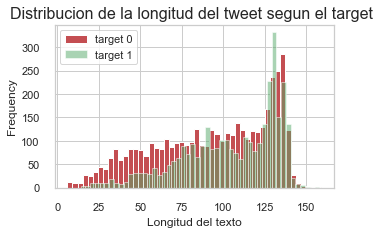

In [8]:

g0 = df.text_length[df['target']== 0].plot.hist(bins=50, color='r', label='target 0')
g1 = df.text_length[df['target']== 1].plot.hist(bins=50, color= 'g', label='target 1', alpha= 0.5)
plt.legend()
plt.xlabel('Longitud del texto', fontsize=12)
plt.title('Distribucion de la longitud del tweet segun el target ', fontsize=16);

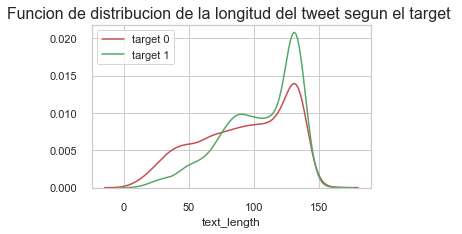

In [9]:
g1 = sns.distplot(df.text_length[df['target']== 0], hist=False, color='r', label='target 0')
g1 = sns.distplot(df.text_length[df['target']== 1], hist=False, color='g', label='target 1')
plt.title('Funcion de distribucion de la longitud del tweet segun el target ', fontsize=16);

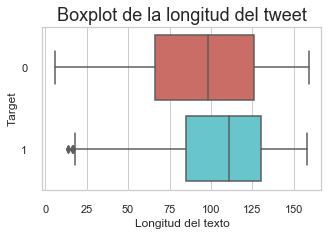

In [10]:
g = sns.boxplot(y="target", x="text_length", data=df, palette="hls", orient='h' )
g.set_title("Boxplot de la longitud del tweet", fontsize=18)
g.set_ylabel("Target", fontsize=12)
g.set_xlabel("Longitud del texto", fontsize=12);

In [11]:
# creamos target_0 y target_1 para evaluar los estadisticos que muestra el boxplot
df['target_0'] = df['text_length'][df['target'] == 0]
df['target_1'] = df['text_length'][df['target'] == 1]
df[['text_length', 'target_0', 'target_1']].describe()

,text_length,target_0,target_1
count,"7,613.00","4,342.00","3,271.00"
mean,98.03,92.91,104.83
std,33.08,35.21,28.65
min,6.00,6.00,14.00
25%,75.00,66.00,85.00
50%,103.00,98.00,111.00
75%,129.00,126.00,130.00
max,159.00,159.00,158.00


Del boxplot y el describe podemos observar que los textos clasificados como falsos (target == 0) tienen mayor variabilidad que los clasififacos como verdaderos. Para evaluar el origen de esta dispersion de datos podemos:  
* Hacer un analisis de outliers
* Hacer una limpieza del texto eliminando caracteres y contando las palabras en vez de la longitud del string


In [12]:
def count_words(text):
    '''
    Funcion que toma un texto y devuelve la cantidad de palabras
    '''
    word_counts = len(text.split(' '))
    return word_counts

In [13]:
df['words'] = df['text'].apply(count_words)
df.head()

,id,keyword,location,text,target,text_length,target_0,target_1,words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,nan,69.00,13
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,37,nan,37.00,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1,132,nan,132.00,22
3,6,NaN,NaN,13000 people receive #wildfires evacuation orders in California,1,64,nan,64.00,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,nan,88.00,17


Repetimos las visualizaciones, ahora utilizando la cantidad de palabras de cada texto

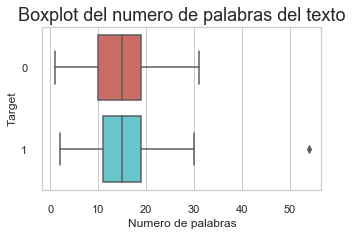

In [14]:
g = sns.boxplot(y="target", x="words", data=df, palette="hls", orient='h' )
g.set_title("Boxplot del numero de palabras del texto", fontsize=18)
g.set_ylabel("Target", fontsize=12)
g.set_xlabel("Numero de palabras", fontsize=12);

Analizando el Boxplot tomando en cuenta la cantidad de palabras de cada texto, nuevamente se observa que los texto falsos tienen una mayor dispersion en los datos que los textos verdaderos. Tambien se observa un registro de mas de 50 palabras. 

In [15]:

df.loc[df['words'] > 50,'text']

5738    Rescuers recover body of 37-year-old Calgary man from lake near Vulcan                                          ÂÃ_ http//tco/gAEhr9bHEk
Name: text, dtype: object

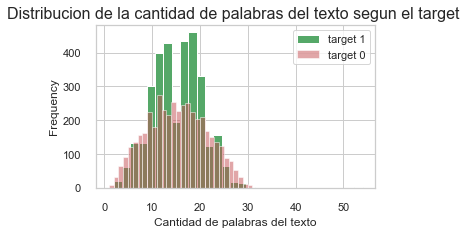

In [16]:

g1 = df.words[df['target']== 1].plot.hist(bins=30, color= 'g', label='target 1')
g0 = df.words[df['target']== 0].plot.hist(bins=30, color='r', label='target 0', alpha= 0.5)
plt.legend()
plt.xlabel('Cantidad de palabras del texto', fontsize=12)
plt.title('Distribucion de la cantidad de palabras del texto segun el target ', fontsize=16);

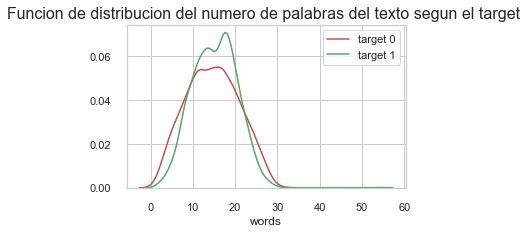

In [17]:
g1 = sns.distplot(df.words[df['target']== 0], hist=False, color='r', label='target 0')
g1 = sns.distplot(df.words[df['target']== 1], hist=False, color='g', label='target 1')
plt.title('Funcion de distribucion del numero de palabras del texto segun el target ', fontsize=16);

In [18]:
# analisis de algunos parametros estadisticos segun el target
promedio = df.groupby(['target']).agg({'words':[ 'mean','median' ,'min', 'max']})
promedio

words               
                       mean median min max
target                                    
0                     14.72     15   1  31
1                     15.20     15   2  54

In [19]:
# reordenamos los indices para facilitar la lectura de los resultados
nivel_0 = promedio.columns.get_level_values(0)
nivel_1 = promedio.columns.get_level_values(1)
promedio.columns = nivel_0 + '_' + nivel_1
promedio.reset_index(inplace=True)
promedio

,target,words_mean,words_median,words_min,words_max
0,0,14.72,15,1,31
1,1,15.20,15,2,54


Observamos que los valores max y min pueden considerarse outliers y debemos analizarlos para evaluar si los eliminamos de nuestro df

In [20]:
tweets_largos = df[df['words'] > 25]
tweets_cortos = df[df['words'] < 5]

In [21]:
tweets_cortos

,id,keyword,location,text,target,text_length,target_0,target_1,words
15,23,NaN,NaN,What's up man,0,13,13.00,nan,3
16,24,NaN,NaN,I love fruits,0,13,13.00,nan,3
17,25,NaN,NaN,Summer is lovely,0,16,16.00,nan,3
19,28,NaN,NaN,What a goooooooaaaaaal,0,22,22.00,nan,3
20,31,NaN,NaN,this is ridiculous,0,18,18.00,nan,3
...,...,...,...,...,...,...,...,...,...
7470,10687,wreck,NaN,I am a wreck,0,12,12.00,nan,4
7558,10805,wrecked,probably not home,coleslaw #wrecked http//tco/sijNBmCZIJ,0,38,38.00,nan,3
7567,10817,wrecked,At your back,Wrecked emotions,0,16,16.00,nan,2
7587,10841,NaN,NaN,Sirens everywhere,0,17,17.00,nan,2


In [22]:
tweets_largos

,id,keyword,location,text,target,text_length,target_0,target_1,words
11,17,NaN,NaN,Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding,1,129,nan,129.00,27
49,71,ablaze,England.,First night with retainers in It's quite weird Better get used to it I have to wear them every single night for the next year at least,0,134,134.00,nan,27
67,96,accident,CLVLND,'I can't have kids cuz I got in a bicycle accident &amp split my testicles it's impossible for me to have kids' MICHAEL YOU ARE THE FATHER,0,138,138.00,nan,27
80,117,accident,NaN,mom 'we didn't get home as fast as we wished' me 'why is that'mom 'there was an accident and some truck spilt mayonnaise all over,0,130,130.00,nan,26
95,137,accident,Charlotte,9 Mile backup on I-77 Southaccident blocking the Right 2 Lanes at Exit 31 Langtree Rdconsider NC 115 or NC 150 to NC 16 as alternate,1,132,nan,132.00,26
...,...,...,...,...,...,...,...,...,...
7450,10662,wounds,The American Wasteland (MV),@FEVWarrior -in the Vault that could take a look at those wounds of yours if you'd like to go to one of these places first' Zarry has had-,0,138,138.00,nan,28
7492,10718,wreck,"Arlington, TX",Got in a car wreck The car in front of me didn't put their blinker on - but it really does feel great outside so lol,0,116,116.00,nan,26
7499,10727,wreck,709?,I still need to finish the lover but I'm watching this other drama for 8 hours now and I'm an emotional wreck so the lover needs to wait,0,136,136.00,nan,28
7513,10746,wreckage,NaN,KUALA LUMPUR Reuters - A piece of a wing that washed up on an Indian Ocean island beach last week was part of the wreckage of Malaysian A,1,137,nan,137.00,28


In [23]:
df.groupby('target')[['words']].quantile([0, 0.25, 0.5, 0.75, 0.95, 1])

words
target                          
0      0.00                 1.00
       0.25                10.00
       0.50                15.00
       0.75                19.00
       0.95                25.00
       1.00                31.00
1      0.00                 2.00
       0.25                11.00
       0.50                15.00
       0.75                19.00
       0.95                23.00
       1.00                54.00

In [24]:
limpio = df[(df['words']> 5) & (df['words']<30)]

In [25]:
limpio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7207 entries, 0 to 7612
Data columns (total 9 columns):
id             7207 non-null int64
keyword        7163 non-null object
location       4832 non-null object
text           7207 non-null object
target         7207 non-null int64
text_length    7207 non-null int64
target_0       4022 non-null float64
target_1       3185 non-null float64
words          7207 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 563.0+ KB


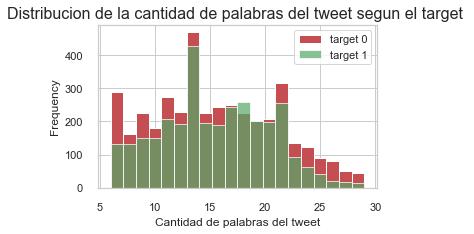

In [36]:

g0 = limpio.words[df['target']== 0].plot.hist(bins=20, color='r', label='target 0')
g1 = limpio.words[df['target']== 1].plot.hist(bins=20, color= 'g', label='target 1', alpha = 0.7)
plt.legend()
plt.xlabel('Cantidad de palabras del tweet', fontsize=12)
plt.title('Distribucion de la cantidad de palabras del tweet segun el target ', fontsize=16);

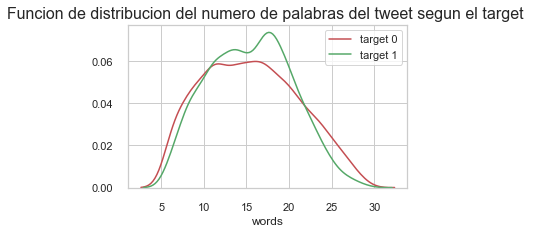

In [27]:
g1 = sns.distplot(limpio.words[df['target']== 0], hist=False, color='r', label='target 0')
g1 = sns.distplot(limpio.words[df['target']== 1], hist=False, color='g', label='target 1')
plt.title('Funcion de distribucion del numero de palabras del tweet segun el target ', fontsize=16);

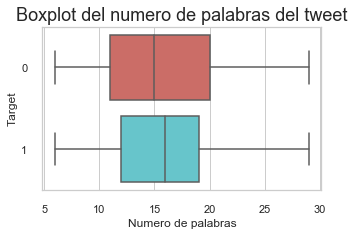

In [28]:
g = sns.boxplot(y="target", x="words", data=limpio, palette="hls", orient='h' )
g.set_title("Boxplot del numero de palabras del tweet", fontsize=18)
g.set_ylabel("Target", fontsize=12)
g.set_xlabel("Numero de palabras", fontsize=12);

In [29]:
limpio['target'].value_counts(normalize=False)

0    4022
1    3185
Name: target, dtype: int64

In [30]:
df['target'].value_counts(normalize=False)

0    4342
1    3271
Name: target, dtype: int64